# Crypto Pairs Trading 


This notebook gives an example of a simple pairs trading strategy. The focus is not on the mathematical part of the strategy but rather on the intuition and demonstration of how such a strategy could work. 

The strategy could be entirely executed in Binance using their API. The files containing code on how to download data and send orders may follow at a later point in time.

## Preparation

I start out by loading all necessary packages and loading the data that I have already downloaded and stored.

In [5]:
# load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns

In [137]:
# load data

df = pd.read_csv('../data/close_s010922_e010223.csv', index_col = 0)

# change index to time
df.index = pd.to_datetime(df.index)

df.head()

,BTCUSDT_close,ETHUSDT_close,BNBUSDT_close,NEOUSDT_close,LTCUSDT_close,QTUMUSDT_close,ADAUSDT_close,XRPUSDT_close,EOSUSDT_close,TUSDUSDT_close,...,POLYXUSDT_close,APTUSDT_close,OSMOUSDT_close,HFTUSDT_close,PHBUSDT_close,HOOKUSDT_close,MAGICUSDT_close,HIFIUSDT_close,RPLUSDT_close,PROSUSDT_close
Time,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,20064.43,1551.37,278.4,8.92,53.73,3.092,0.4451,0.3278,1.355,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 01:00:00,20127.45,1559.59,279.4,8.95,54.19,3.112,0.4482,0.3265,1.366,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 02:00:00,20118.09,1557.13,277.8,8.98,55.12,3.116,0.4479,0.3247,1.369,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 03:00:00,20022.97,1549.91,277.6,8.94,54.30,3.097,0.4455,0.3237,1.362,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 04:00:00,20055.59,1551.79,277.6,8.96,54.76,3.107,0.4482,0.3256,1.363,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The .csv file contains the close prices of all available tokens on Binance between the 1st of Sep 2022 and 1st of Feb 2023. In this notebook I will not be using the entire data set as there will probably be enough interesting pairs in a subset of the data. If desired, the entire code could be scaled to the entire data set. 

## Data analysis

As I am not interested in individual time series, I will briefly look at some descriptive statistics to make sure the data looks correct and adjust if needed. Binance's data however has been very reliable in my experience. 

In [101]:
# select the first 20 tokens
df = df.iloc[:, :20]
df.describe()

,BTCUSDT_close,ETHUSDT_close,BNBUSDT_close,NEOUSDT_close,LTCUSDT_close,QTUMUSDT_close,ADAUSDT_close,XRPUSDT_close,EOSUSDT_close,TUSDUSDT_close,IOTAUSDT_close,XLMUSDT_close,ONTUSDT_close,TRXUSDT_close,ETCUSDT_close,ICXUSDT_close,NULSUSDT_close,VETUSDT_close,USDCUSDT_close,LINKUSDT_close
count,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,603.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,3673.000000,603.000000,3673.000000
mean,18843.324040,1371.107637,281.955486,7.712284,66.294264,2.501626,0.364487,0.402438,1.079354,0.999949,0.231973,0.096839,0.199365,0.058439,23.360485,0.202417,0.202846,0.021036,0.999936,6.922782
std,1981.725428,162.629944,22.707794,0.993205,12.412577,0.414869,0.070620,0.054076,0.203987,0.000121,0.038292,0.015644,0.028116,0.004364,5.806506,0.041126,0.022994,0.002936,0.000113,0.715362
min,15649.520000,1081.190000,225.400000,5.980000,49.160000,1.776000,0.240600,0.315500,0.811000,0.999600,0.159200,0.070800,0.145600,0.046260,15.020000,0.139800,0.161600,0.015360,0.999600,5.394000
25%,16856.850000,1249.390000,270.000000,6.800000,54.830000,2.121000,0.314100,0.353900,0.920000,0.999900,0.207100,0.085000,0.175600,0.054370,19.450000,0.162700,0.188300,0.018840,0.999900,6.390000
50%,19114.740000,1313.610000,279.400000,7.800000,63.270000,2.564000,0.357900,0.389400,1.043000,1.000000,0.227000,0.092400,0.204100,0.060280,21.970000,0.204100,0.195300,0.022180,1.000000,6.949000
75%,20173.570000,1548.950000,295.100000,8.530000,76.450000,2.848000,0.423900,0.456500,1.156000,1.000000,0.262700,0.111800,0.223100,0.062290,26.990000,0.236500,0.212200,0.023340,1.000000,7.405000
max,23897.840000,1783.400000,375.400000,10.230000,97.140000,3.412000,0.523100,0.539900,1.848000,1.000200,0.325100,0.130200,0.258700,0.065480,41.520000,0.295700,0.365700,0.028080,1.000200,9.112000


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3673 entries, 2022-09-01 00:00:00 to 2023-02-01 00:00:00
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BTCUSDT_close   3673 non-null   float64
 1   ETHUSDT_close   3673 non-null   float64
 2   BNBUSDT_close   3673 non-null   float64
 3   NEOUSDT_close   3673 non-null   float64
 4   LTCUSDT_close   3673 non-null   float64
 5   QTUMUSDT_close  3673 non-null   float64
 6   ADAUSDT_close   3673 non-null   float64
 7   XRPUSDT_close   3673 non-null   float64
 8   EOSUSDT_close   3673 non-null   float64
 9   TUSDUSDT_close  603 non-null    float64
 10  IOTAUSDT_close  3673 non-null   float64
 11  XLMUSDT_close   3673 non-null   float64
 12  ONTUSDT_close   3673 non-null   float64
 13  TRXUSDT_close   3673 non-null   float64
 14  ETCUSDT_close   3673 non-null   float64
 15  ICXUSDT_close   3673 non-null   float64
 16  NULSUSDT_close  3673 non-null   float64
 17  VETUS

The data looks good, there doesn't seem to be any outliers and the values lie within the ranges I expect for that period. However, I will remove TUSD and USDC as there is not as much data as I would like. 

In [103]:
df = df.drop(['TUSDUSDT_close', 'USDCUSDT_close'], axis = 1)

## Strategy

The strategy relies on pairs of coins that follow a similar price path. Specifically, I am looking for coins which prices always stay within a certain range. The idea is that if the prices actually move in tandem, any larger disrepancy between them will be corrected in the future. 

For example: If A and B are such a pair, then if A increases by a lot and B remains the same, the expectation is that either B will follow and increase, or A will move back into the range and decrease again. 

By taking a long position in B and a short in A, we can in theory profit from either outcome.

What we are looking for are cointegrated pairs. While there are a handful of methods to calculate the cointegration, I will be testing whether the difference of 2 time series are stationary, indicating that the difference lies within a specific range as it has a constant mean and variance. I will use the Augmented Dickey Fuller (ADF) test to test this.

To circumvent the issue of different scales (if A is very large and B is very small the same percentual change will have a much larger effect on A than on B thus making their difference larger eventhough they follow the same path) I will take the log of the prices. An alternative would be to rescale and test on cumulative returns. 

In [104]:
# preprocess

df_log = np.log(df)

# alternative
#df = (df.pct_change().fillna(0) + 1).cumprod()

# as the adfuller function uses logs we cannot have any 0 in our df, lets check
(df_log == 0).any()

BTCUSDT_close     False
ETHUSDT_close     False
BNBUSDT_close     False
NEOUSDT_close     False
LTCUSDT_close     False
QTUMUSDT_close    False
ADAUSDT_close     False
XRPUSDT_close     False
EOSUSDT_close      True
IOTAUSDT_close    False
XLMUSDT_close     False
ONTUSDT_close     False
TRXUSDT_close     False
ETCUSDT_close     False
ICXUSDT_close     False
NULSUSDT_close    False
VETUSDT_close     False
LINKUSDT_close    False
dtype: bool

In [105]:
# we can see that EOS contains a 0, let us replace it with something else close to 0
df_log = df_log.replace(0, 0.001)

# check again
(df_log == 0).any()

BTCUSDT_close     False
ETHUSDT_close     False
BNBUSDT_close     False
NEOUSDT_close     False
LTCUSDT_close     False
QTUMUSDT_close    False
ADAUSDT_close     False
XRPUSDT_close     False
EOSUSDT_close     False
IOTAUSDT_close    False
XLMUSDT_close     False
ONTUSDT_close     False
TRXUSDT_close     False
ETCUSDT_close     False
ICXUSDT_close     False
NULSUSDT_close    False
VETUSDT_close     False
LINKUSDT_close    False
dtype: bool

In [106]:
# function to test ADF on pairwise time series

def testADF(df):
    
    # number of coins
    n = df.shape[1]
    
    # significance matrix
    sig_mat = np.zeros((n, n))
    
    # loop through each column
    for i in range(n):
        
        # pair with each proceeding column
        for j in range(i + 1, n):
            
            # take the difference
            diff = df.iloc[:, i] - df.iloc[:, j]
            
            # calculate ADF and store pvalue
            sig_mat[i, j] = adfuller(diff)[1] 
            
    return sig_mat

In [107]:
sig_mat = testADF(df_log)

Text(0.5, 1.0, 'Heatmap of pairwise significance of stationarity between log prices')

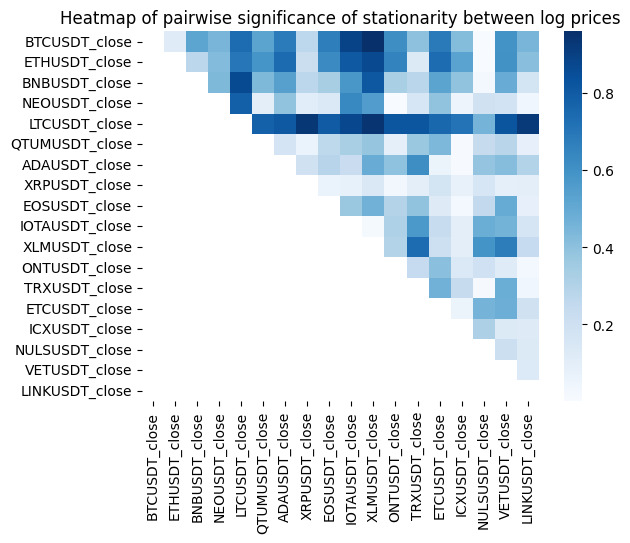

In [108]:
# plot the matrix

ax = sns.heatmap(sig_mat, 
            xticklabels = df_log.columns, 
            yticklabels = df_log.columns, 
            mask = np.tril(np.ones_like(sig_mat)),
            cmap = 'Blues')

ax.set_title('Heatmap of pairwise significance of stationarity between log prices')

We are looking for low p values. We can see that there are some lower values that very likely are stationary. I will sort the results and select the most significant result to analyze our strategy.

In [109]:
df_results = pd.DataFrame(sig_mat,
                          columns = df.columns,
                          index = df.columns)

# array contains 0 which we will replace with 5 to not select incorrect pair
df_results.replace(0, 5).stack().sort_values().head(5)

NEOUSDT_close   ONTUSDT_close     0.001710
ETHUSDT_close   NULSUSDT_close    0.001763
BTCUSDT_close   NULSUSDT_close    0.002669
QTUMUSDT_close  ICXUSDT_close     0.006951
ADAUSDT_close   ICXUSDT_close     0.007114
dtype: float64

NEO and ONT fit best together according to the test. Lets visualize the difference to verify what it looks like.

<AxesSubplot: title={'center': 'log difference of NEO and ONT'}, xlabel='Time'>

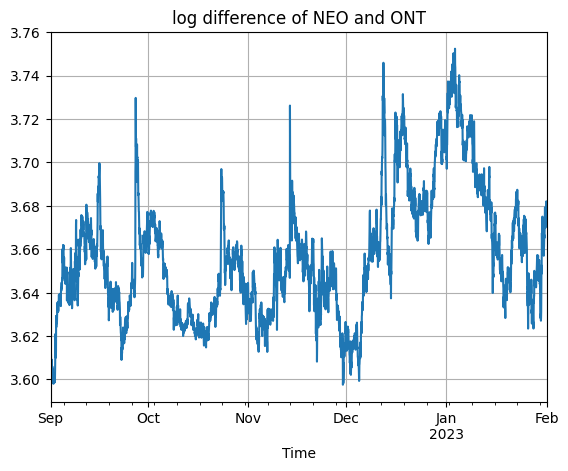

In [110]:
# create pair
df_pair = df_log.NEOUSDT_close - df_log.ONTUSDT_close
df_pair.plot(title = 'log difference of NEO and ONT', grid = True)

It indeed looks like the series is stationary and the difference between logs moves within a range. 

The important part is that if it ever was far away from the mean, it at some point reverts back. This is what the strategy tries to profit from. 

Lets look at some further plots that can help us determine when the difference is large enough to consider it a clear deviation from the normal range.

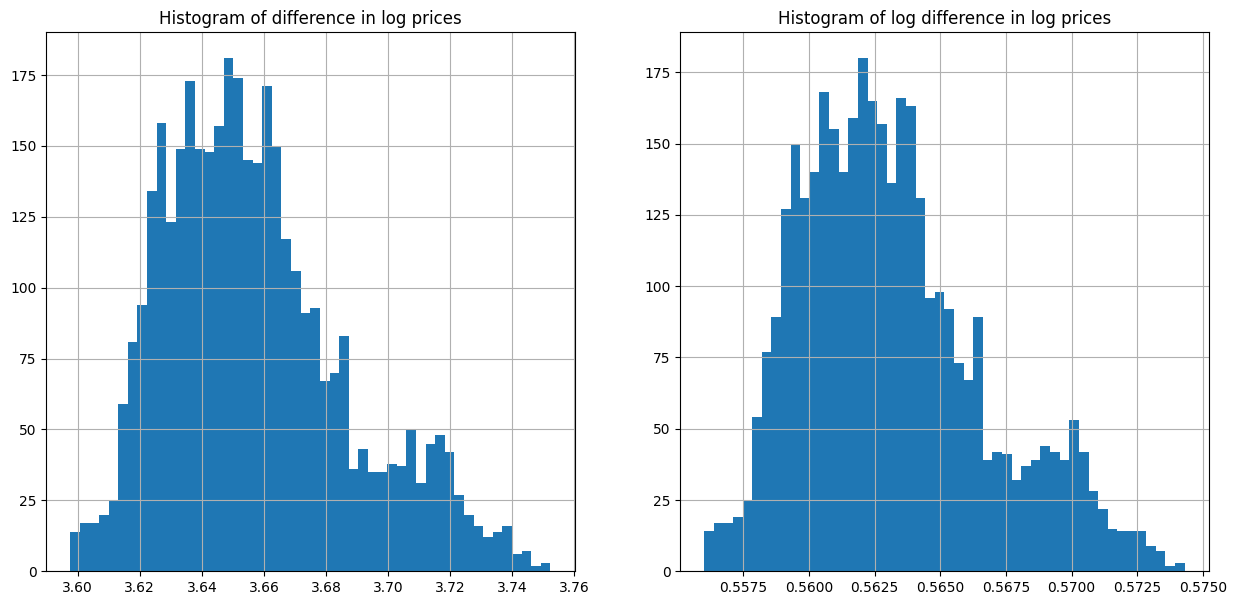

In [111]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 7))

df_pair.hist(bins = 50, ax = ax[0])
ax[0].set_title('Histogram of difference in log prices')

np.log10(df_pair).hist(bins = 50, ax = ax[1])
ax[1].set_title('Histogram of log difference in log prices')

plt.show()

There is a heavy right tail that is also not fixed by taking the log10. The goal is the find a distribution that matches the data. In this case I will just assume that the data is normal eventhough it is obviously not. There seems to be a slight bimodality in the data aswell. This may be to the longer time horizon analyzed and this including 2 regimes. In future versions I will try to fit the data with another distribution e.g. Beta or use shorter time intervals. 

I will start out by standardizing the series such that it becomes easier to determine when to send a trading signal. 

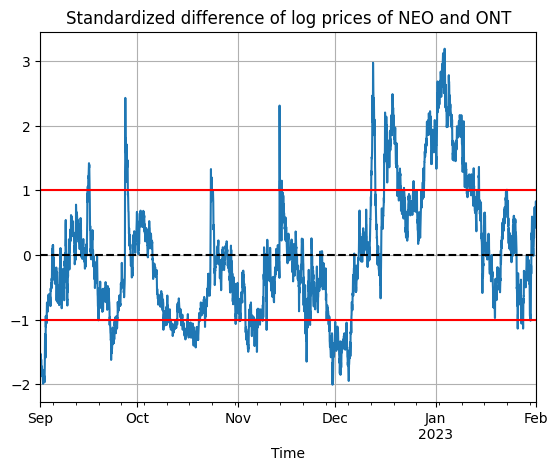

In [112]:
# standardized 
df_z = (df_pair - df_pair.mean()) / df_pair.std()

ax = df_z.plot(title = 'Standardized difference of log prices of NEO and ONT', grid = True)
ax.axhline(y = 1, color = 'r')
ax.axhline(y = -1, color = 'r')
ax.axhline(y = 0, color = 'black', linestyle = '--')

From the above plot it looks to be a good idea to send a trading signal when the difference falls below -1, or rises above 1, at least until December. Afterwards we have some strong divergence to the top although it does revert back to the mean again afterwards. 

## Backtest

Now to backtest the strategy. I will loop through every time step and check whether the difference suggests a trade should be made according to the rule above. If the difference is below -1, a long position in NEO and a short in ONT will be opened and vice versa if the difference goes above 1 as explained in the example above. 

In [173]:
def runBackTest(df, upper_sig, lower_sig):

    # start with no positions
    trade = 0
    
    # create df to store trades
    df_trades = pd.DataFrame(columns = ['date', 'open1', 'close1', 'open2', 'close2', 'side'])
    
    # calculate difference in log prices
    df_log = np.log(df.iloc[:, 0]) - np.log(df.iloc[:, 1])
    
    # create standardized difference
    z = (df_log - df_log.mean()) / df_log.std()
    
    # iterate through time
    for t in range(len(z)):
        
        # not in a trade
        if trade == 0:
            
            # check if upper signal triggered
            if z.iloc[t] > upper_sig:
                
                # change status of trade
                trade = 1
                
                # record prices
                open_ = df.iloc[t]
                
            # if lower signal triggered
            elif z.iloc[t] < lower_sig:

                trade = -1
                open_ = df.iloc[t]
        
        # if already in a trade look for exit signal
        elif trade == 1:
            
            # arbitrary reversal condition (for now)
            if z.iloc[t] < upper_sig - 0.2:
                
                close = df.iloc[t]
                date = df.index[t]
                
                df_trades.loc[len(df_trades)] = [date, open_[0], close[0], 
                                                 open_[1], close[1], trade]

                trade = 0

        elif trade == -1:

            if z.iloc[t] > lower_sig + 0.2:
                
                close = df.iloc[t]
                date = df.index[t]
                
                df_trades.loc[len(df_trades)] = [date, open_[0], close[0], 
                                                 open_[1], close[1], trade]

                trade = 0
    
    # create rows to store return from open to close of positions
    df_trades['ret1'] = np.nan
    df_trades['ret2'] = np.nan
    #df_trades['date'] = pd.to_datetime(df_trades.date)
    df_trades = df_trades.set_index('date')
    
    # calculate returns depending on which trade was done
    for t in range(len(df_trades)):

        # if we longed coin 2 and shorted coin 1
        if df_trades.iloc[t, 4] == 1:

            df_trades.iloc[t, 5] = df_trades.iloc[t, 0] / df_trades.iloc[t, 1]

            df_trades.iloc[t, 6] = df_trades.iloc[t, 3] / df_trades.iloc[t, 2]

        else:

            df_trades.iloc[t, 5] = df_trades.iloc[t, 1] / df_trades.iloc[t, 0]

            df_trades.iloc[t, 6] = df_trades.iloc[t, 2] / df_trades.iloc[t, 3]

    # assuming equal weights we take the average of the returns
    returns = df_trades[['ret1', 'ret2']].mean(axis = 1)

    # calculate cumulative rturns
    total_ret = returns.cumprod()                            

    return total_ret

<AxesSubplot: title={'center': 'Cumulative return of pairs trading strategy'}, xlabel='date'>

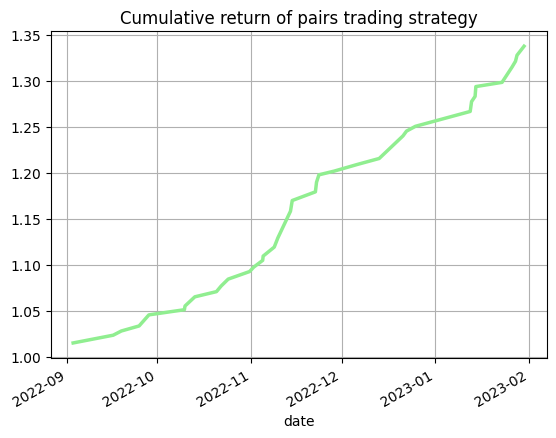

In [175]:
total_ret = runBackTest(df[['NEOUSDT_close', 'ONTUSDT_close']], 1, -1)

total_ret.plot(title = 'Cumulative return of pairs trading strategy',
               grid = True,
               lw = 2.5,
               color = 'lightgreen')

As we can see the strategy had indeed been profitable over the 6 months. However, it is pivotal to note that we had the data and could set a z score that matched the data very well. The next step would be to separate the data into training and test data for which the results would probably not look as promising.

It is also important to mention that we have not taken any fees account here. Although Binance is rather affordable, this would still decrease the profitability of the strategy.

The next steps are to introduce a training and test data set, find a better distribution of the difference, then experiment with different signals to open and close a trade and test in cross validation.